In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, deltaE_ciede94
from skimage import io
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [2]:
# functions
def get_ksize(sigma):
    return int(((sigma - 0.8)/0.15) + 2.0)

def get_gaussian_blur(img, ksize=0, sigma=5):
    if ksize == 0:
        ksize = get_ksize(sigma)
    sep_k = cv2.getGaussianKernel(ksize, sigma)
    return cv2.filter2D(img, -1, np.outer(sep_k, sep_k))

def ssr(img, sigma):
    img = img.astype('float32') / 255  # Convert to float and normalize
    blurred = get_gaussian_blur(img, sigma=sigma)
    return np.log10(img + 1e-6) - np.log10(blurred + 1e-6)

# MSR function
def msr(img, sigma_scales=[15, 80, 250]):
    msr_img = np.zeros(img.shape)
    for sigma in sigma_scales:
        msr_img += ssr(img, sigma)
    msr_img = msr_img / len(sigma_scales)
    msr_img = cv2.normalize(msr_img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return msr_img

In [3]:

def color_balance(img, low_per, high_per):
    tot_pix = img.shape[1] * img.shape[0]
    low_count = tot_pix * low_per / 100
    high_count = tot_pix * (100 - high_per) / 100
    ch_list = [img] if len(img.shape) == 2 else cv2.split(img)
    cs_img = []
    for ch in ch_list:
        ch = ch.astype('float32')  # Ensure the channel is in float32 for calculations
        cum_hist_sum = np.cumsum(cv2.calcHist([ch.astype('uint8')], [0], None, [256], (0, 256)))  # Convert to uint8 for cv2.calcHist
        li, hi = np.searchsorted(cum_hist_sum, (low_count, high_count))
        lut = np.array([0 if i < li else (255 if i > hi else round((i - li) / (hi - li) * 255)) for i in np.arange(0, 256)], dtype='uint8')
        cs_ch = cv2.LUT(ch.astype('uint8'), lut)  # Ensure ch is converted to uint8 before applying LUT
        cs_img.append(cs_ch)
    return cv2.merge(cs_img) if len(cs_img) > 1 else cs_img[0]


def msrcr(img, sigma_scales=[15, 80, 250], alpha=125, beta=46, G=192, b=-30, low_per=1, high_per=1):
    img = img.astype(np.float64) + 1.0
    msr_img = msr(img, sigma_scales)  
    crf = beta * (np.log10(alpha * img) - np.log10(np.sum(img, axis=2, keepdims=True)))
    msrcr_img = G * (msr_img * crf - b)
    msrcr_img = cv2.normalize(msrcr_img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
    msrcr_img = color_balance(msrcr_img, low_per, high_per)
    return msrcr_img

In [4]:
def msrcp(img, sigma_scales=[15, 80, 250], low_per=1, high_per=1):
    int_img = (np.sum(img, axis=2) / img.shape[2]) + 1.0
    msr_int = msr(int_img, sigma_scales)
    msr_cb = color_balance(msr_int, low_per, high_per)
    B = 256.0 / (np.max(img, axis=2) + 1.0)
    BB = np.array([B, msr_cb/int_img])
    A = np.min(BB, axis=0)
    msrcp = np.clip(np.expand_dims(A, 2) * img, 0.0, 255.0)

    return msrcp.astype(np.uint8)

In [5]:
# Load the image
#image_path = 'C:/Users/shaia/Documents/Opgaveregning/AutoSys/1. semester/Computational billedbehandling og spektroskopi/34269_computer_imaging_and_spectroscopy/low_light_enhancement/images/2015_00173.jpg'
image_path = '/home/eaguiraud/Documents/34269_computer_imaging_and_spectroscopy/low_light_enhancement/images/dark_img_1.png'
img = cv2.imread(image_path, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for correct color display


In [6]:
# Apply MSR
msr_img = msr(img)

# Normalize MSR image for display
msr_img_normalized = cv2.normalize(msr_img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


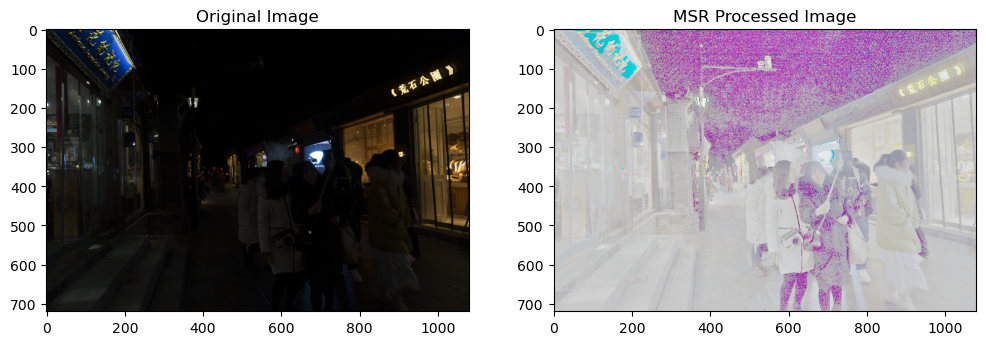

In [7]:
# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(msr_img_normalized)
plt.title('MSR Processed Image')

plt.show()

In [8]:
# Apply MSRCR
msrcr_img = msrcr(img)

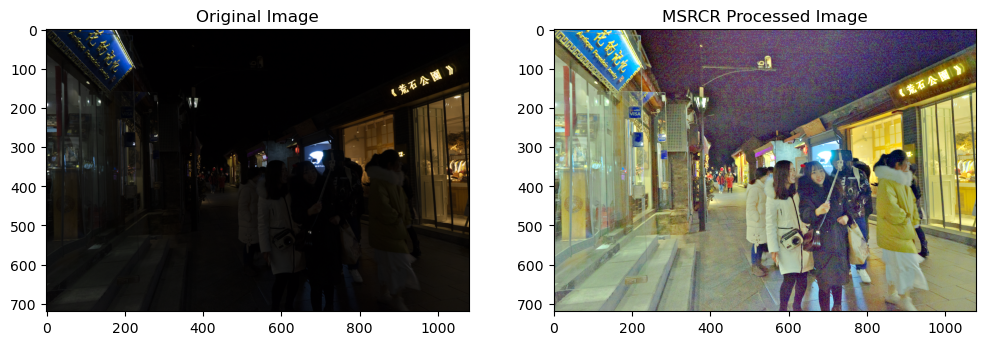

In [9]:
# Display the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(msrcr_img)
plt.title('MSRCR Processed Image')
plt.show()

In [10]:
# Apply MSRCP
msrcp_img = msrcp(img)


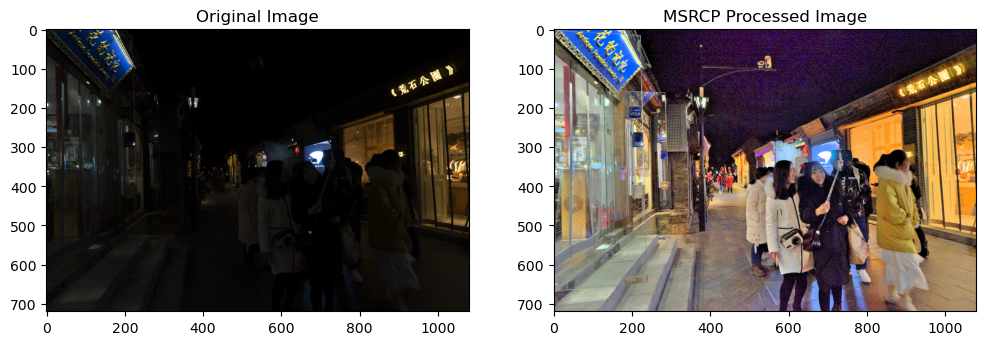

In [11]:
# Display the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(msrcp_img)
plt.title('MSRCP Processed Image')
plt.show()

In [12]:
im_orgLAB = rgb2lab(img)
eval_ssim = deltaE_ciede94(im_orgLAB, im_orgLAB)
np.mean(eval_ssim)

1.330906005124211e-08

/tmp/ipykernel_15248/3830431352.py:2: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  eval_psnr = psnr(img, msr_img_normalized)


SSIM result:	0.09773749463853879
PSNR result:	18.457571993297357
Delta_E average result:	72.97129302682472


Text(0.5, 1.0, 'Delta E as an image')

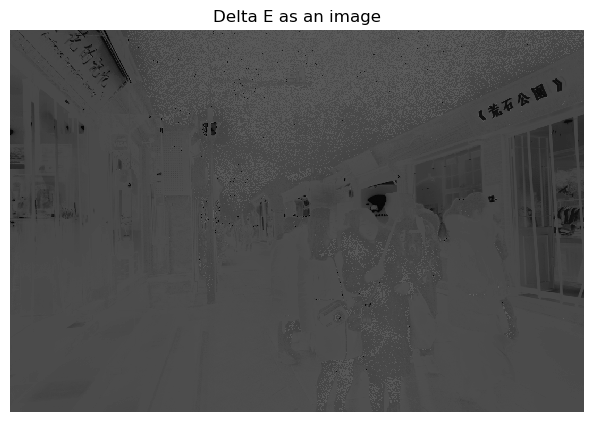

In [13]:
eval_ssim = ssim(img, msr_img_normalized, data_range = msr_img_normalized.max() - msr_img_normalized.min(), win_size = 3)
eval_psnr = psnr(img, msr_img_normalized)
im_orgLAB = rgb2lab(img)
im_enhLAB = rgb2lab(msr_img_normalized)
eval_coldif = deltaE_ciede94(im_orgLAB, im_enhLAB)

print("SSIM result:\t" + str(eval_ssim) + "\nPSNR result:\t" + str(eval_psnr) + "\nDelta_E average result:\t" + str(np.mean(eval_coldif)))

plt.figure()
io.imshow(np.uint8(np.round(eval_coldif)))
plt.axis("off")
plt.title("Delta E as an image")

SSIM result:	0.09456990372312031
PSNR result:	7.265333289959522
Delta_E average result:	51.84029948257414


Text(0.5, 1.0, 'Delta E as an image')

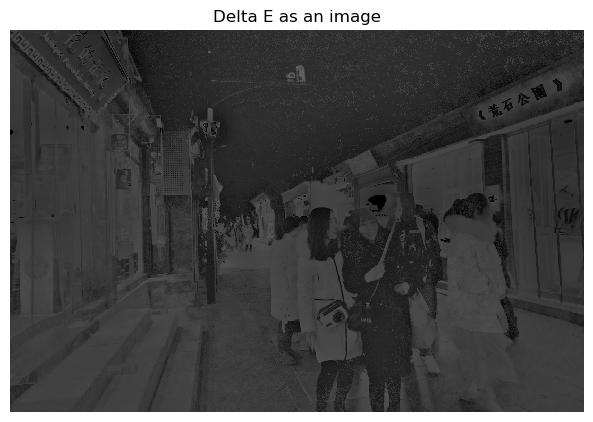

In [14]:
eval_ssim = ssim(img, msrcr_img, data_range = msrcr_img.max() - msrcr_img.min(), win_size = 3)
eval_psnr = psnr(img, msrcr_img)
im_orgLAB = rgb2lab(img)
im_enhLAB = rgb2lab(msrcr_img)
eval_coldif = deltaE_ciede94(im_orgLAB, im_enhLAB)

print("SSIM result:\t" + str(eval_ssim) + "\nPSNR result:\t" + str(eval_psnr) + "\nDelta_E average result:\t" + str(np.mean(eval_coldif)))

plt.figure()
io.imshow(np.uint8(np.round(eval_coldif)))
plt.axis("off")
plt.title("Delta E as an image")

SSIM result:	0.11823249729285001
PSNR result:	8.38944837637934
Delta_E average result:	40.90007177253315


Text(0.5, 1.0, 'Delta E as an image')

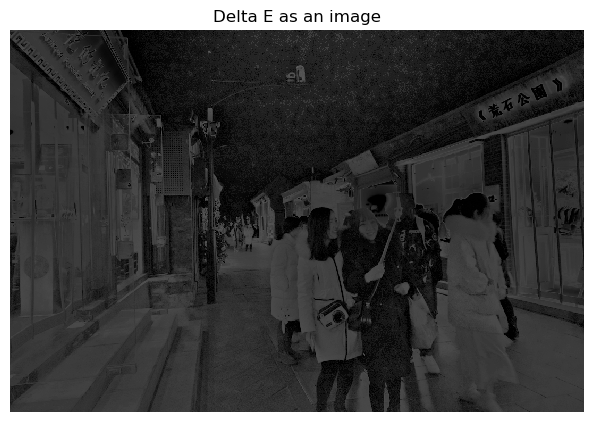

In [15]:
eval_ssim = ssim(img, msrcp_img, data_range = msrcp_img.max() - msrcp_img.min(), win_size = 3)
eval_psnr = psnr(img, msrcp_img)
im_orgLAB = rgb2lab(img)
im_enhLAB = rgb2lab(msrcp_img)
eval_coldif = deltaE_ciede94(im_orgLAB, im_enhLAB)

print("SSIM result:\t" + str(eval_ssim) + "\nPSNR result:\t" + str(eval_psnr) + "\nDelta_E average result:\t" + str(np.mean(eval_coldif)))

plt.figure()
io.imshow(np.uint8(np.round(eval_coldif)))
plt.axis("off")
plt.title("Delta E as an image")